In [ ]:
# 🏠 House Price Index Forecasting using Macroeconomic Indicators

# 1. Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import shap
import warnings
warnings.filterwarnings('ignore')

# 2. Load and Inspect Data
df = pd.read_csv("dataset.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%y')
df = df.sort_values('Date').reset_index(drop=True)

print("Data shape:", df.shape)
df.head()


Data shape: (425, 13)


,Date,house_price_index,population,house_supply,gdp,mortgage_rate,employment_rate,permit_new,ppi_res,m3,cci,delinquency_rate,hcai
0,1987-01-01,63.965,241857,6.0,99.902813,9.2040,70.163085,1690.0,100.0,2.7439,100.4624,NaN,NaN
1,1987-02-01,64.424,242005,6.2,99.875864,9.0825,70.289205,1689.0,100.4,2.7475,100.4945,NaN,NaN
2,1987-03-01,64.735,242166,6.0,99.869734,9.0350,70.321678,1704.0,100.7,2.7537,100.5720,NaN,NaN
3,1987-04-01,65.132,242338,6.0,99.882087,9.8325,70.499062,1601.0,101.1,2.7677,100.6568,NaN,NaN
4,1987-05-01,65.565,242516,6.7,99.910371,10.5960,70.808308,1500.0,101.3,2.7729,100.6919,NaN,NaN


In [ ]:
# 3. Preprocessing
# Drop columns with too many missing values (e.g., 'hcai')
df = df.drop(columns=['hcai'])

# Fill remaining missing values (forward fill)
df.fillna(method='ffill', inplace=True)

# Define target and features
target = 'house_price_index'
features = df.columns.drop(['Date', target])

X = df[features]
y = df[target]


In [ ]:
# 4. Time-Aware Train-Test Split
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (340, 10)
Test size: (85, 10)


In [ ]:
# 5. Train XGBoost Model
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)


In [ ]:
# 6. Evaluate Performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Calculate RMSE by taking the square root of MSE
r2 = r2_score(y_test, y_pred)
within_10 = np.mean(np.abs((y_test - y_pred) / y_test) <= 0.10) * 100
within_20 = np.mean(np.abs((y_test - y_pred) / y_test) <= 0.20) * 100

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Predictions within ±10%: {within_10:.2f}%")
print(f"Predictions within ±20%: {within_20:.2f}%")


RMSE: 58.60
R² Score: -2.0119
Predictions within ±10%: 17.65%
Predictions within ±20%: 68.24%


In [ ]:
# 5. Define Custom Loss Function: Squared Percentage Error (SPE)
def spe_obj(y_true, y_pred):
    grad = -2 * (y_true - y_pred) / (y_true ** 2)
    hess = 2 / (y_true ** 2)
    return grad, hess


In [ ]:
# 6. Train XGBoost with Custom Loss (SPE)
model_spe = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    objective=spe_obj,
    random_state=42
)
model_spe.fit(X_train, y_train)

# Predict
y_pred_spe = model_spe.predict(X_test)


In [ ]:
# 7. Evaluation for SPE model
rmse_spe = np.sqrt(mean_squared_error(y_test, y_pred_spe)) # Calculate RMSE using np.sqrt
r2_spe = r2_score(y_test, y_pred_spe)
within_10_spe = np.mean(np.abs((y_test - y_pred_spe) / y_test) <= 0.10) * 100
within_20_spe = np.mean(np.abs((y_test - y_pred_spe) / y_test) <= 0.20) * 100

print("🔧 Custom Loss (SPE) Model Performance:")
print(f"RMSE: {rmse_spe:.2f}")
print(f"R² Score: {r2_spe:.4f}")
print(f"Predictions within ±10%: {within_10_spe:.2f}%")
print(f"Predictions within ±20%: {within_20_spe:.2f}%")



🔧 Custom Loss (SPE) Model Performance:
RMSE: 214.70
R² Score: -39.4360
Predictions within ±10%: 0.00%
Predictions within ±20%: 0.00%


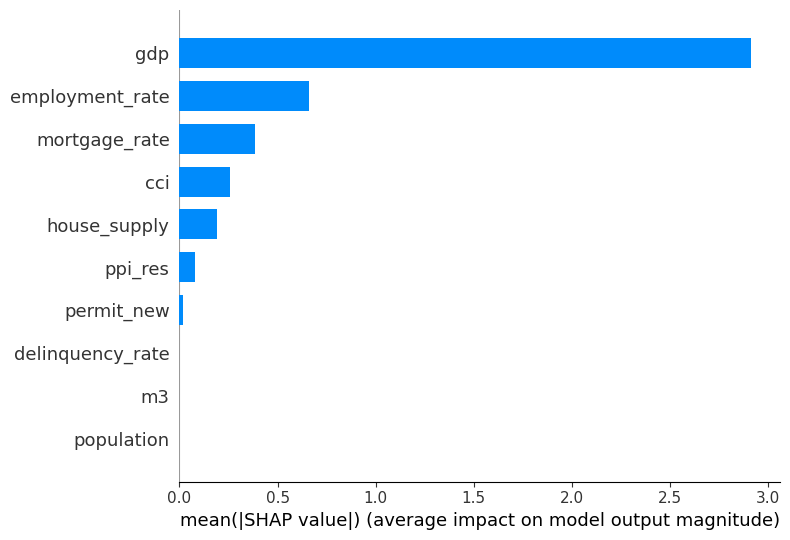

In [ ]:
# 7. SHAP Interpretability
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")
